In [1]:
#Run only once
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/DeepLearningMachine/JointAngleMeasurement


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from PIL import Image, ImageOps
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import imutils
from src.helper_functions import *

Using TensorFlow backend.


In [4]:
#Fix cuDNN incompatibility issue
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
train_path = 'data/Poses/train'
valid_path = 'data/Poses/valid'
test_path = 'data/Poses/test'

In [6]:
#Load in images and place them into training batches
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=5)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=3)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=5)

Found 285 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [7]:
imgs, labels = next(train_batches)

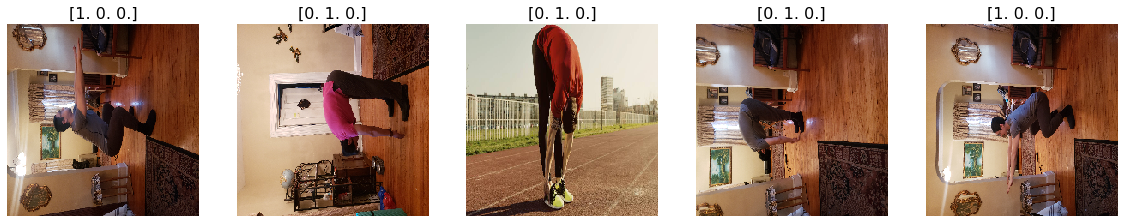

In [8]:
plots(imgs, titles=labels)

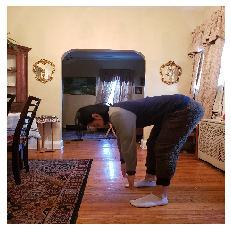

In [9]:
bending_img = cv.imread('data/Poses/train/bending/20200511_190442.jpg')
bending_img = cv.resize(bending_img, (244, 244))
plt.axis('off')
plt.imshow(cv.cvtColor(bending_img, cv.COLOR_BGR2RGB))
plt.show()

In [10]:
vgg16_model = tf.keras.applications.vgg16.VGG16()


In [11]:
#Make Sequential Model out of Base VGG16 Model
Pose_Analyzer_Model = Sequential()
for layer in vgg16_model.layers[:-1]:
    Pose_Analyzer_Model.add(layer)

In [12]:
#Freeze layers that have already been trained
for layer in Pose_Analyzer_Model.layers[:-1]:
    layer.trainable = False

In [13]:
#Add final dense layer to predict our classes: Squat, Bending Over, Hands over head
num_classes = 3
Pose_Analyzer_Model.add(Dense(3, activation='softmax'))

In [14]:
Pose_Analyzer_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)

In [16]:
Pose_Analyzer_Model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
Pose_Analyzer_Model.fit(train_batches, steps_per_epoch=57, validation_data=valid_batches, validation_steps=22, epochs=12, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 57 steps, validate for 22 steps
Epoch 1/12
57/57 - 24s - loss: 1.2177 - accuracy: 0.7263 - val_loss: 0.2661 - val_accuracy: 0.9545
Epoch 2/12
57/57 - 23s - loss: 0.0400 - accuracy: 0.9895 - val_loss: 0.2036 - val_accuracy: 0.9697
Epoch 3/12
57/57 - 23s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1960 - val_accuracy: 0.9697
Epoch 4/12
57/57 - 23s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9697
Epoch 5/12
57/57 - 23s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1919 - val_accuracy: 0.9697
Epoch 6/12
57/57 - 23s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1925 - val_accuracy: 0.9697
Epoch 7/12
57/57 - 23s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9697
Epoch 8/12
57/57 - 23s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1923 - val_accuracy: 0.9697
Epoch 9/12
57/57 - 23s - loss: 9.2765e-04 - accuracy: 1.0000 - val_loss: 0.1932 - val_accuracy: 0.9697
Epoch 10/12
5

In [18]:
Pose_Analyzer_Model.save('saved_model_info/Pose_Analyzer_VGG16_model.h5')

In [19]:
test_imgs, test_labels = next(test_batches)

In [ ]:
raising arms
bending
raising arms
bending
squatting

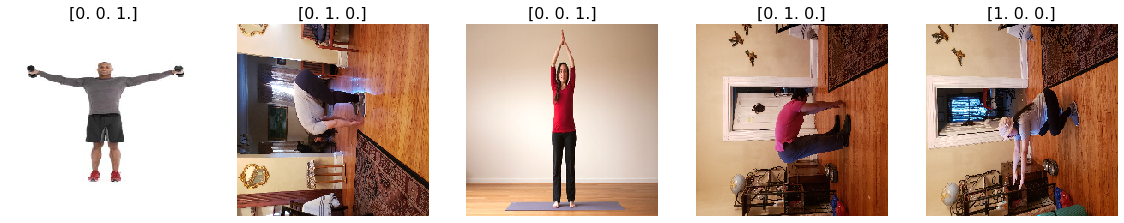

In [20]:
plots(test_imgs, titles=test_labels)

In [21]:
predictions = Pose_Analyzer_Model.predict_generator(test_batches, steps=8, verbose=0)

Instructions for updating:
Please use Model.predict, which supports generators.


In [22]:
df_cm = pd.DataFrame(predictions)

In [23]:
'''
squat           1 0 0
bending         0 1 0
raising arms    0 0 1
'''

'\nsquat           1 0 0\nbending         0 1 0\nraising arms    0 0 1\n'

In [25]:
#Decode and print predictions
decoded = tf.argmax(predictions, axis=1)
for i in np.array(decoded):
    if i == 0:
        print('squatting')
    elif i == 1:
        print('bending')
    elif i == 2:
        print('raising arms')
    else:
        print('unknown pose detected')

raising arms
bending
raising arms
bending
squatting
raising arms
squatting
raising arms
bending
squatting
raising arms
squatting
bending
squatting
squatting
bending
bending
raising arms
squatting
raising arms
squatting
squatting
raising arms
raising arms
squatting
squatting
bending
raising arms
bending
bending
squatting
raising arms
squatting
raising arms
squatting
raising arms
bending
bending
bending


In [89]:
for i in df_cm.index:
    df_cm['Prediction'] = 'Sin' 

In [79]:
import seaborn as sn

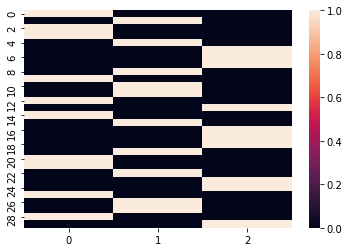

In [81]:
sn.heatmap(df_cm)
plt.show()

In [74]:
from sklearn.metrics import plot_confusion_matrix